In [1]:
# Analysis Suite
import sys
import scipy
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from IPython import embed
import seaborn as sns

In [2]:
# Development Suite
import datetime as dt
import IPython
from IPython import embed
import csv
from datetime import timedelta
%matplotlib inline

In [3]:
def ate(eater):
    if eater:
        did_eat = np.random.choice([True,False], p = [.95,.05])
    else:
        did_eat = np.random.choice([True,False], p = [.8, .2])
    
    if did_eat:
        return 1
    else:
        return 2
    
def slept(sleeper):
    if sleeper == 0:
        how_slept = np.random.choice([3,4,5,6,7], p = [.1, .3, .3, .25, .05])
    elif sleeper == 1:
        how_slept = np.random.choice([3,4,5,6,7], p = [.05, .25, .3, .3, .1])
    else:
        how_slept = np.random.choice([3,4,5,6,7], p = [0, .1, .4, .3, .2])
    return how_slept

In [4]:
def figure_grade(res):
    food = res[0::2]
    food = sum([2 if n == 1 else 1 for n in food])
    sleep = sum(res[1::2])
    max_sleep = 70
    max_food = 20
    
    sleep_prop = sleep/max_sleep
    food_prop = food/max_food
    # Injected a lot of noise into the model here...
    grade = (food_prop * 50) + (sleep_prop * 50) + np.random.normal(scale = 4)
    if grade > 100:
        grade = 100
        
    return grade

In [5]:
# Run this cell to create a new dataset
num_students = 5000
num_classes = 250
# 1 is food and 2 is sleep
questions = {1: [1,2], 2: range(3,8)}

day = timedelta(days=1)
start = dt.datetime(2019,1,2)

to_ret = []
survey_collector = []
for s in range(num_students):
    eater = np.random.choice([True,False],p = [.4,.6])
    sleeper = np.random.choice([0,1,2], p= [.4, .4,.2])
    c = s // 20 # 20 students per class
    for d in range(30):
        ts = (start + day * d).strftime('%Y-%m-%d %I:%M:%S') # increment by one day
        q1 = ate(eater)
        q2 = slept(sleeper)
        survey_collector.extend([q1,q2])
        to_ret.append({'student_id': s, 'course_id': c, 'question_id': 1, 'choice_id': q1,
                       'choice_type': 'id', 'correct': 'nil', 'created_at': ts, 'updated_at': ts })
        to_ret.append({'student_id': s, 'course_id': c, 'question_id': 2,
                       'choice_id': q2, 'choice_type': 'id', 'correct': 'nil', 'created_at': ts, 'updated_at': ts })
        if d % 10 == 9: # test every 10 days
            grade = figure_grade(survey_collector)
            to_ret.append({'student_id': s, 'course_id': c, 'question_id': 3, 'choice_id': grade, 
                           'choice_type': 'text', 'correct': 'nil', 'created_at': ts, 'updated_at': ts })
            survey_collector = []

In [6]:
# Binds dataset to df variable
df = pd.DataFrame(to_ret)

In [7]:
# Saves dataset to CSV file in Django app
df.to_csv('../data/cool_student_seed_data.csv', index=False)

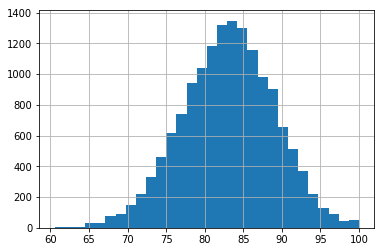

In [8]:
# Histogram of grade distributions for mock students
df[(df.question_id == 3)]['choice_id'].hist(bins=30)

In [9]:
def data_parse(quiz_data, survey_data):
    student_array = []
    for index, row in quiz_data.iterrows():
        columns = ['choice_id','choice_id_4.0','choice_id_5.0','choice_id_6.0','choice_id_7.0']
        if index == 0:
            survey_date = survey_data[(survey_data.created_at <= row.created_at)]
            percent_survey = []
            for col in columns:
                try:
                    x = survey_date[col].value_counts(normalize=True).loc[1]
                except: # doesn't account for if there are no surveys
                    x = 0.0
                percent_survey.append(x)
                
            student_array.append({'score':row['choice_id'], 
                                  'data': percent_survey})
        else:
            survey_date = survey_data[(survey_data.created_at <= row.created_at) 
                                      & (survey_data.created_at > quiz_data.iloc[index - 1].created_at) ]
            percent_survey = []
            for col in columns:
                try:
                    x = survey_date[col].value_counts(normalize=True).loc[1]
                except: # doesn't account for if there are no surveys
                    x = 0.0
                percent_survey.append(x)
                
            student_array.append({'score':row['choice_id'], 
                                  'data': percent_survey})
    return student_array

In [10]:
# Run to munge dataset and associate test scores with specific sets of sleep and food data
dataset = []
criteria = ['choice_id', 'created_at']

sleep_dummies = pd.get_dummies(df[(df.question_id == 2)], drop_first=True, columns=['choice_id'])

for s in df.student_id.unique():
    food_data = df[(df.student_id == s) & (df.question_id == 1)] # food data for student
    food_data = food_data[['created_at', 'choice_id']]
    idx = (food_data['choice_id'] == 2)
    food_data.loc[idx,['choice_id']] = food_data.loc[idx,['choice_id']] - 2 

    sleep_data = sleep_dummies[(sleep_dummies.student_id == s)] # sleep data for student
    sleep_data = sleep_data[['created_at','choice_id_4.0','choice_id_5.0', 'choice_id_6.0', 'choice_id_7.0']]

    survey_data = pd.concat([food_data, sleep_data], sort=False).sort_values(['created_at'])

    quiz_data = df[(df.student_id == s) & (df.question_id == 3)]
    quiz_data = quiz_data.sort_values(['created_at'])[['choice_id', 'created_at']].reset_index()

    student_data = data_parse(quiz_data, survey_data)
    
    for record in student_data:
        dataset.append(record)

In [11]:
# sklearn Analysis Suite
from sklearn import model_selection
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error

from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

In [12]:
X = []
y = []

for record in dataset:
    X.append(record['data'])
    y.append(record['score'])

test_size = 0.20
seed = 7

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, 
                                                                    test_size=test_size, 
                                                                    random_state=seed)

In [ ]:
# Run this cell for hyperparameter tuning and model selection

# max_depth options in linear space from None - 100
max_depth = [int(x) for x in np.linspace(1, 20, num = 11)]
max_depth.append(None)

tree_params = {
               'max_depth': max_depth,
               'n_estimators': np.logspace(1, 5, num=10, dtype='int')
               }

adaboost_params = {
                'base_estimator': [DecisionTreeRegressor(max_depth=3), DecisionTreeRegressor(max_depth=4), DecisionTreeRegressor(max_depth=5)],
                'learning_rate' : [0.01,0.05,0.1,0.3,1,2],
                'loss' : ['linear', 'square'],
                'n_estimators': np.logspace(1, 4, num=10, dtype='int')
                }

gboost_params = {
                'learning_rate' : [0.01,0.05,0.1,0.3,1,2],
                'n_estimators': np.logspace(1, 4, num=10, dtype='int'),
                'loss' : ['ls', 'lad']  
                }

models = []
models.append(('ABR', AdaBoostRegressor(), adaboost_params))
models.append(('RFR', RandomForestRegressor(), tree_params))
models.append(('GBR', GradientBoostingRegressor(), gboost_params))
models.append(('ETR', ExtraTreesRegressor(), tree_params))

# Evaluate each model and pick most optimized model with associated hyper parameters
results = []
names = []
best_estimators = []
all_best_params = []
all_cv_results = []
all_model_results = []

for name, model, params in models:
    rs_cv = model_selection.RandomizedSearchCV(estimator=model,
                                               param_distributions=params,
                                               cv=5,
                                               random_state=seed)

    model_result = rs_cv.fit(X_train, y_train)
    best_estimator = model_result.best_estimator_
    score = model_result.best_score_
    best_params = model_result.best_params_
    cv_results = model_result.cv_results_
    
    all_model_results.append(model_result)
    all_cv_results.append(cv_results)
    all_best_params.append(best_params)
    best_estimators.append(best_estimator)
    results.append(score)
    names.append(name)
    msg = "%s: %f" % (name, score)
    print(msg)

In [ ]:
# Graphs results of hyperparameter tuning process and model selection
test_results = {}

for idx, cv in enumerate(all_cv_results):
    test_results[names[idx]] = cv['mean_test_score']

df_results = pd.DataFrame(test_results)

# Compare Algorithms Visually
fig, ax = plt.subplots()
fig.suptitle('Algorithm Comparison')
ax.set_ylabel('Scoring')
ax.set_xlabel('Estimator Type')
sns.swarmplot(data=df_results)
plt.show()

In [ ]:
# Choose best model from hyperparameter selection
max_value = max(results)
max_index = results.index(max_value)
best_model = best_estimators[max_index]

In [13]:
# Unpickle current best_model for usage
import pickle
with open('../data/models/grade_prediction_gbr_model.pickle', "rb") as f:
       best_model = pickle.load(f)

In [14]:
# Predict grade outcomes based on best model
predictions = best_model.predict(X_test)

print("r2_score: %f" % r2_score(y_test, predictions)) # north star of averall performance
print("     MAE: %f" % mean_absolute_error(y_test, predictions)) # good for overall error
print("   MedAE: %f" % median_absolute_error(y_test, predictions)) # robust against large outliers

r2_score: 0.533279
     MAE: 3.299455
   MedAE: 2.803753


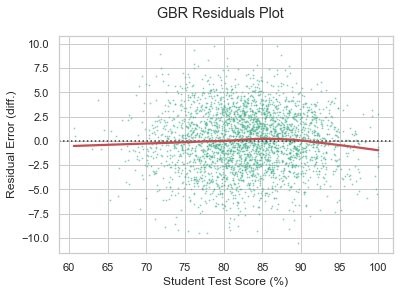

In [31]:
# Residuals plot of predicted scores vs actual test scores

import statsmodels

fig = plt.figure()
sns.set(style="whitegrid")
fig.suptitle('GBR Residuals Plot')
plt.xlabel('Student Test Score (%)') # plot on figure axis
plt.ylabel('Residual Error (diff.)')

sns.residplot(x=y_test, 
              y=predictions, 
              color="b", 
              lowess=True, 
              scatter_kws={'marker': '.', 's':3, 'alpha':0.5, 'color': "#4CB391"}, 
              line_kws={'color': 'r'})
plt.show()
fig.savefig('../machinelearning/media/residuals_plot.png', dpi=1200) # Saves figure to django app

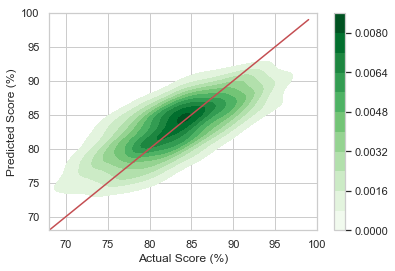

In [32]:
# Kernel density plot of predicted scores vs actual test scores
minimum = 68
maximum = 100

limits = (minimum,maximum)

fig = plt.figure()
plt.xlabel('Actual Score (%)') # plot on figure axis
plt.ylabel('Predicted Score (%)')

axes = fig.gca() # get current axes
axes.set_xlim(limits)
axes.set_ylim(limits)

plt.plot(range(minimum, maximum), range(minimum, maximum), color='r')

sns.kdeplot(y_test, predictions,cmap='Greens', cbar=True, shade=True, shade_lowest=False)

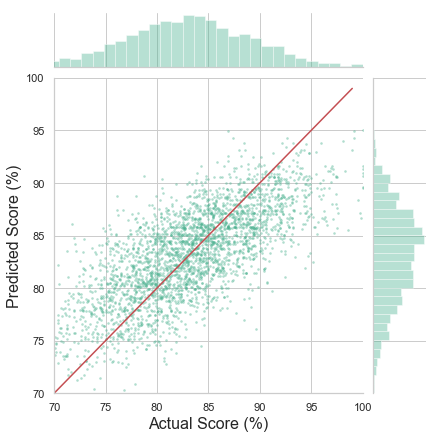

In [33]:
# Seaborn joint plot combination of histograms and scatterplot
min = 70
max = 100

g = sns.jointplot(y_test , predictions, kind="scatter", joint_kws={'alpha':0.3, 's':3},xlim=(min, max), ylim=(min,max), color="#4CB391" )
ax1 = g.ax_joint.plot(range(min, max), range(min, max), color='r')

g.set_axis_labels('Actual Score (%)', 'Predicted Score (%)', fontsize=16)

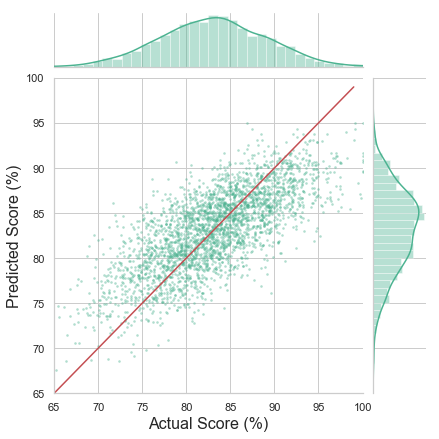

In [34]:
# Seaborn joint plot combination of distribution plots and scatterplot

min = 65
max = 100

g = sns.JointGrid(y_test , predictions,xlim=(min, max), ylim=(min,max))
g = g.plot_joint(plt.scatter, alpha=0.3, s=3, color="#4CB391")
g = g.plot_marginals(sns.distplot, color="#4CB391")
g.ax_joint.plot(range(min, max), range(min, max), color='r')

g.set_axis_labels('Actual Score (%)', 'Predicted Score (%)', fontsize=16)

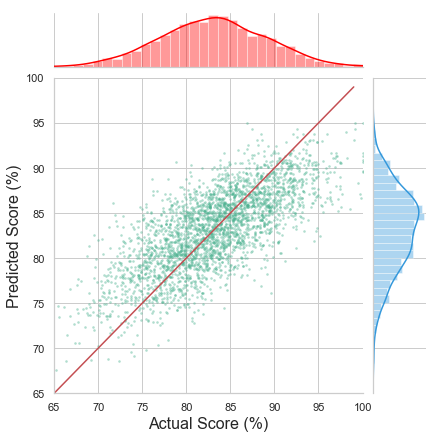

In [37]:
# Seaborn joint plot combination of different colored distribution plots and scatterplot

min = 65
max = 100

g = sns.JointGrid(y_test , predictions,xlim=(min, max), ylim=(min,max))
g.plot_joint(plt.scatter, alpha=0.3, s=3, color="#4CB391")
sns.distplot(y_test, label='Actual', color='red', ax=g.ax_marg_x)
sns.distplot(predictions, label='Predicted', vertical=True, color="#3498db", ax=g.ax_marg_y)
g.ax_joint.plot(range(min, max), range(min, max), color='r')

g.set_axis_labels('Actual Score (%)', 'Predicted Score (%)', fontsize=16)
g.savefig('../machinelearning/media/joint_plot.png', dpi=1200) # Saves figure to django app

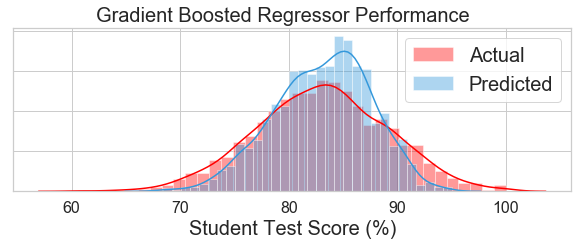

In [36]:
# Seaborn distibution plots overlay
fig, ax = plt.subplots(figsize=(10,3))
test_axes = sns.distplot(y_test, ax=ax, label='Actual', color='red')
dist_axes = sns.distplot(predictions, ax=ax, label='Predicted', color="#3498db")
fig.suptitle('Gradient Boosted Regressor Performance', fontsize='20')
ax.set_xlabel('Student Test Score (%)', fontsize='20')
ax.set_yticklabels([])
ax.tick_params(labelsize='16')
ax.legend(fontsize='20')
plt.show()
fig.savefig('../machinelearning/media/distplot_comparison.png', dpi=1200) # Saves figure to django app

In [18]:
# Run this cell for actual student data from Sinatra Heroku App
from pandas.io.json import json_normalize
import requests
import json
import dateutil.parser

response = requests.get('https://aqueous-caverns-33840.herokuapp.com/api/v1/answers')
data = json.loads(response.text)['data']

data_array = []
for record in data:
    data_array.append(record['attributes'])
    
df_answer = pd.DataFrame(data_array)
df_answer = df_answer[['question_id','course_id','student_id', 'created_at','text_answer']]
df_answer['created_at'] = pd.to_datetime(df_answer['created_at'], format='%Y%m%d %H:%M:%S')
df_answer = df_answer.rename({'text_answer': 'choice_id'}, axis='columns')
                 
response = requests.get('https://aqueous-caverns-33840.herokuapp.com/api/v1/responses')
data = json.loads(response.text)['data']

data_array = []
for record in data:
    data_array.append(record['attributes'])
    
df_response = json_normalize(data_array)
df_response = df_response[['question_id','course_id','student_id', 'created_at','choice_id']]
df_response['created_at'] = pd.to_datetime(df_response['created_at'], format='%Y%m%d %H:%M:%S')

df = pd.concat([df_answer, df_response])
df['choice_id'] = df['choice_id'].astype('float64')
df['student_id'] = df['student_id'].astype('int64')

In [ ]:
# Save best model for future use
def pickle_file('../data/models/grade_prediction_gbr_model.pickle', obj):
    with open(path, 'wb') as f:
        pickle.dump(obj, f)

pickle_file(file_path, best_model)